Notebook to produce the final plot for comparing the RNASeq GSEA results between our ICB cohort and the GLASS non-ICB cohort. One plot for newly diagnosed samples and one for recurrent. The methodology for the confidence intervals (and determining significance) uses a Leave-1-Out approach to ensure no gene set is made to be significant that relies on just one sample.

In [1]:
import sys
sys.path.insert(1, '../src/')

In [2]:
import pandas as pd
import pickle
import os
import re
import math
import numpy as np
from matplotlib import pyplot as plt

Configuration

In [3]:
gsea_results_dir = '../data/gsea_outputs/'

# Load GSEA outputs
This shows results from the Leave-1-Out Trials, labeling (with CI) all the gene sets that are significant in our ICB cohort in either Newly Diagnosed or Recurrent. This significance test is based on the maximum (least signficant) p-value from all the Leave-1-Out trials. The point is colored by significant difference in two cohorts (red), significant in ICB but not significantly different (blue) or not significant (gray - but still labeled if it is colored in the other cohort).

In [4]:
def load_bootstrap_rna(outdir, run_spec):
    full_gsea_df = pd.read_pickle(os.path.join(outdir, run_spec + '_all_gsea_iterations.pkl'))
    summary_df = pd.read_pickle(os.path.join(outdir, run_spec + '_gsea_summary.pkl'))
    store_samples = pd.read_pickle(os.path.join(outdir, run_spec + '_samples.pkl'))
    full_sv_limma = pd.read_pickle(os.path.join(outdir, run_spec + '_full_sv_limma.pkl'))

    return full_gsea_df, summary_df, store_samples, full_sv_limma

In [6]:
limma_pre_newD_leaveONEout_fgsea_full_gsea_df, \
limma_pre_newD_leaveONEout_fgsea_summary_df, \
limma_pre_newD_leaveONEout_fgsea_store_samples, \
limma_pre_newD_leaveONEout_fgsea_full_sv_limma = load_bootstrap_rna(gsea_results_dir, 'pre_NewD_onlyProtein_leaveONEout_fgsea_180_last')

limma_pre_rec_leaveONEout_fgsea_full_gsea_df, \
limma_pre_rec_leaveONEout_fgsea_summary_df, \
limma_pre_rec_leaveONEout_fgsea_store_samples, \
limma_pre_rec_leaveONEout_fgsea_full_sv_limma = load_bootstrap_rna(gsea_results_dir, 'pre_Recurrent_onlyProtein_leaveONEout_fgsea_180_last')

limma_glass_primary_leaveONEout_fgsea_full_gsea_df, \
limma_glass_primary_leaveONEout_fgsea_summary_df, \
limma_glass_primary_leaveONEout_fgsea_store_samples, \
limma_glass_primary_leaveONEout_fgsea_full_sv_limma = load_bootstrap_rna(gsea_results_dir, 'glass_noIdhMut_noICB_primary_leaveONEout_fgsea')

limma_glass_recurrent_leaveONEout_fgsea_full_gsea_df, \
limma_glass_recurrent_leaveONEout_fgsea_summary_df, \
limma_glass_recurrent_leaveONEout_fgsea_store_samples, \
limma_glass_recurrent_leaveONEout_fgsea_full_sv_limma = load_bootstrap_rna(gsea_results_dir, 'glass_noIdhMut_noICB_recurrent_leaveONEout_fgsea')

In [7]:
with open(os.path.join('../data/gsea_outputs', 'combined_pre_NewD_svaUsesHeldOutSamples_GSEA_180_last.pkl'), 'rb') as f:
    limma_pre_newly_diagnosed_combined_gsea = pickle.load(f)
with open(os.path.join('../data/gsea_outputs', 'combined_pre_Rec_svaUsesHeldOutSamples_GSEA_180_last.pkl'), 'rb') as f:
    limma_pre_recurrent_combined_gsea = pickle.load(f)

limma_pre_newly_diagnosed_combined_gsea = limma_pre_newly_diagnosed_combined_gsea.get_results().set_index("Term")
limma_pre_recurrent_combined_gsea = limma_pre_recurrent_combined_gsea.get_results().set_index("Term")

# Define plotting functions

In [8]:
keep_upper = set(["DNA", "GBM", "IL2", "IL6", "STAT3", "STAT5", "JAK", "TGF", "MYC", "TNFA", "NFKB", "MTORC1", "KRAS", "MHC", "II", "G2M"])

def pathway_nicename(pwy, to_replace={"HALLMARK": "", "GLIOBLASTOMA": "GBM",
                                      "KEGG_MEDICUS_REFERENCE_ANTIGEN_PROCESSING_AND_PRESENTATION_BY_MHC": "MHC"}, 
                          keep_upper=keep_upper, 
                          to_lower=set(["VIA", "V1", "V2"]),
                          max_line_len=20):
    for k, v in to_replace.items():
        pwy = pwy.replace(k, v)
    tks = pwy.upper().split("_")
    #tks = [to_replace[tk] if tk in to_replace.keys() else tk for tk in tks]
    tks = [tk.capitalize() if (tk not in keep_upper) else tk for tk in tks]
    tks = [tk.lower() if (tk.upper() in to_lower) else tk for tk in tks]
    result = " ".join(tks).strip()
    
    return result

def nompvals_to_logpvals(nompvals, min_pval=1e-20):
    nompvals = np.array(nompvals)
    logpvals = nompvals[:]
    logpvals[logpvals == 0] = min_pval
    logpvals = -( np.log10(logpvals) )
    return logpvals

def prepare_pscatter_data(x_summary_df, y_summary_df, comparison_df, min_pval=1e-20):

    n_dots = x_summary_df.shape[0]
    
    # X values
    plt_x = nompvals_to_logpvals(x_summary_df["FDR q-val"].values, min_pval=min_pval)
    x_sgns = np.sign(x_summary_df["NES"].values)
    plt_x = plt_x * x_sgns

    # X errorbar values
    maxp_x = nompvals_to_logpvals(x_summary_df["max_FDR q-val"].astype(float).values, min_pval=min_pval)
    xerr = np.zeros((2, plt_x.shape[0]))
    xerr[0, x_sgns > 0] = (plt_x - maxp_x)[x_sgns > 0]
    xerr[1, x_sgns < 0] = (-maxp_x - plt_x)[x_sgns < 0]

    # Y values
    plt_y = nompvals_to_logpvals(y_summary_df["FDR q-val"].values, min_pval=min_pval)
    y_sgns = np.sign(y_summary_df["NES"].values)
    plt_y = plt_y * y_sgns

    # Y errorbar values
    maxp_y = nompvals_to_logpvals(y_summary_df["max_FDR q-val"].astype(float).values, min_pval=min_pval)
    yerr = np.zeros((2, plt_y.shape[0]))
    yerr[0, y_sgns > 0] = (plt_y - maxp_y)[y_sgns > 0]
    yerr[1, y_sgns < 0] = (-maxp_y - plt_y)[y_sgns < 0]

    sizes = [40]*n_dots
    
    # Colors
    colors = np.array(["gray"]*n_dots)
    colors[x_summary_df["max_FDR q-val"] < 0.1] = "red"
    colors[y_summary_df["max_FDR q-val"] < 0.1] = "blue"
    colors[(y_summary_df["max_FDR q-val"] < 0.1) & (x_summary_df["max_FDR q-val"] < 0.1)] = "m"
    
    # Whether to show errorbars
    #errorbar_statuses = np.array([False]*n_dots)
    errorbar_statuses = (x_summary_df["max_FDR q-val"] < 0.1) | (y_summary_df["max_FDR q-val"] < 0.1)
    #errorbar_statuses[comparison_df["FDR q-val"] < 0.1] = True
    
    return plt_x, plt_y, xerr, yerr, sizes, colors, errorbar_statuses


In [9]:
# Annotations
def generate_annot_ls(to_annotate,
                      x_summary_df, y_summary_df,
                      plt_x, plt_y, seed=123):
    np.random.seed = seed
    result = []    
    for i, gs in enumerate(x_summary_df.index.values):
        x = plt_x[i]
        y = plt_y[i]
        if gs in to_annotate:
            name = pathway_nicename(gs)
        else:
            name = ""
        result.append({"text": name,
                       "xy": (x,y),
                       "xytext": (x+ np.sign(x)*np.abs(np.random.randn()),
                                  y+ np.sign(y)*np.abs(np.random.randn())
                                 ),
                       "arrowprops": {"width": 0.05,
                                      "linewidth":0.25,
                                      "headwidth": 3.0, 
                                      "headlength": 4.0,
                                      "color": "black"
                                     }
                      })
    return result

def update_annot(annot_ls, update_dict, x_summary_df):
    gs_to_idx = {gs: i for i, gs in enumerate(x_summary_df.index.values)}
    for gs, d in update_dict.items():
        idx = gs_to_idx[gs]
        annot_ls[idx] = {**annot_ls[idx], **d, "text": pathway_nicename(gs)}

    return annot_ls    

def update_errorbar_status(errorbar_status, override_ls, srt_names):
    name_to_idx = {n:i for i, n in enumerate(srt_names)}
    for name in override_ls:
        errorbar_status[name_to_idx[name]] = True

    return errorbar_status

In [10]:
def plot_pscatter(plt_x, plt_y, xerr, yerr, sizes, 
                  colors, errorbar_status, 
                  annotations, figsize=(6,6)):
    
    fig, ax = plt.subplots(figsize=figsize)
    n_dots = len(plt_x)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    xlim = max(abs(plt_x.min()), abs(plt_x.max())) * 1.1
    ax.set_xlim([-xlim, xlim])
    ylim = max(abs(plt_y.min()), abs(plt_y.max())) * 1.1
    ax.set_ylim([-ylim, ylim])

    ax.plot([-xlim, xlim], [0,0], 'k', linewidth=0.5)
    ax.plot([0,0], [-ylim, ylim], 'k', linewidth=0.5)

    for i in range(n_dots):
        if errorbar_status[i]:
            ax.errorbar([plt_x[i]], [plt_y[i]], xerr=np.transpose([xerr[:,i]]), yerr=np.transpose([yerr[:,i]]), ecolor=colors[i], linestyle="none", marker="none", capsize=2.0)
        ax.scatter([plt_x[i]], [plt_y[i]], s=sizes[i], color=colors[i], linewidths=0.0, alpha=0.8)
        if annotations[i]["text"] != "":
            ax.annotate(**annotations[i])

    maxlim = max(xlim, ylim)
    ax.plot([-maxlim, maxlim], [-maxlim, maxlim], linestyle="--", color="silver", linewidth=0.9, alpha=0.8, zorder=-999)
    
    return fig, ax


In [11]:
def gsea_plot(x_summary_df, y_summary_df, comparison_df, to_annotate, annotate_override={}, errorbar_status_override=[], figsize=(6,6), seed=123):

    srt_idx = np.sort(x_summary_df.index.values)
    x_summary_df = x_summary_df.loc[srt_idx,:]
    y_summary_df = y_summary_df.loc[srt_idx,:]
    comparison_df = comparison_df.loc[srt_idx,:]
    
    plt_x, plt_y, xerr, yerr, sizes, colors, errorbar_status = prepare_pscatter_data(x_summary_df, y_summary_df, comparison_df)

    annot_ls = generate_annot_ls(to_annotate, 
                                 x_summary_df, y_summary_df,
                                 plt_x, plt_y,
                                 seed=seed)
    annot_ls = update_annot(annot_ls, annotate_override, x_summary_df)
    errorbar_status = update_errorbar_status(errorbar_status, errorbar_status_override, srt_idx)
    
    fig, ax = plot_pscatter(plt_x, plt_y, xerr, yerr, sizes, colors, 
                            errorbar_status, annot_ls, figsize=figsize)
    
    return fig, ax

In [12]:
def volcano_plot(scores, q_values, alpha=0.1, xlabel="Normalized Enrichment Score", ylabel="$-\log_{10} (q$-value$)$"):
    plot_y = nompvals_to_logpvals(q_values)
    plt.scatter(scores, plot_y, marker=".")
    log_alpha = -np.log10(alpha)
    y_max = max(1.5*log_alpha, np.max(plot_y)*1.25)
    x_lim = np.max(np.abs(scores))*1.125

    plt.xlim(-x_lim, x_lim)
    plt.ylim(0, y_max)
    plt.plot([-x_lim, x_lim], [log_alpha, log_alpha], linestyle="--", color="k", linewidth=0.8)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    

# GSEA plots

Text(0.03, 0.7, 'better survival$\\rightarrow$')

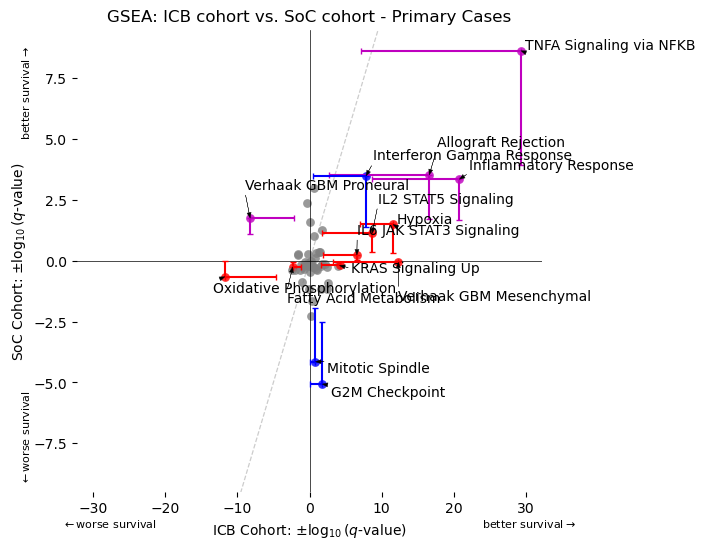

In [13]:
to_annotate = ((limma_pre_newD_leaveONEout_fgsea_summary_df["max_FDR q-val"] < 0.1) | 
               (limma_glass_primary_leaveONEout_fgsea_summary_df["max_FDR q-val"] < 0.1))
to_annotate = to_annotate[to_annotate].index.tolist()

fig, ax = gsea_plot(limma_pre_newD_leaveONEout_fgsea_summary_df,
                   limma_glass_primary_leaveONEout_fgsea_summary_df,
                   limma_pre_newly_diagnosed_combined_gsea,
                   to_annotate,
                    seed=314159
              )
ax.set_title("GSEA: ICB cohort vs. SoC cohort - Primary Cases")
ax.set_xticks([-30, -20, -10, 0, 10, 20, 30])
ax.set_xlabel(r"ICB Cohort: $\pm \log_{10} (q$-value$)$")
ax.set_ylabel(r"SoC Cohort: $\pm \log_{10} (q$-value$)$")
fig.text(0.1, 0.05, "$\leftarrow$worse survival", fontsize=8)  
fig.text(0.8, 0.05, r"better survival$\rightarrow$", fontsize=8) 
fig.text(0.03, 0.125, r"$\leftarrow$worse survival", fontsize=8, rotation=90)  
fig.text(0.03, 0.7, r"better survival$\rightarrow$", fontsize=8, rotation=90)

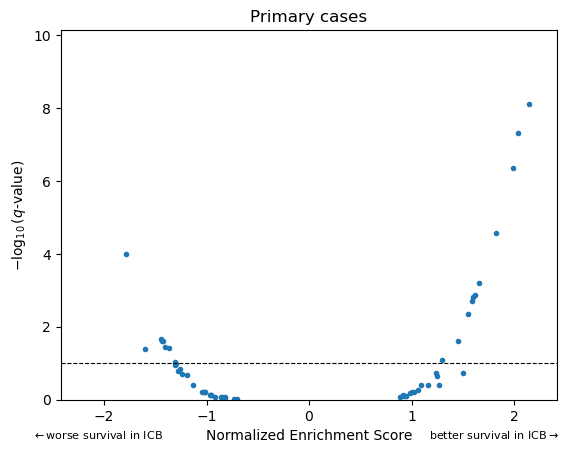

In [14]:
volcano_plot(limma_pre_newly_diagnosed_combined_gsea["NES"].values,
             limma_pre_newly_diagnosed_combined_gsea["FDR q-val"].values)
plt.title("Primary cases")
plt.annotate(r"$\leftarrow$worse survival in ICB", xy=(0.05, 0.03), xycoords="figure fraction", fontsize=8)  
plt.annotate(r"better survival in ICB$\rightarrow$", xy=(0.67, 0.03), xycoords="figure fraction", fontsize=8) 
plt.show()

In [15]:
limma_pre_newly_diagnosed_combined_gsea.loc[limma_pre_newly_diagnosed_combined_gsea["FDR q-val"] < 0.1, ["NES", "FDR q-val"]].sort_values("NES")

,NES,FDR q-val
Term,,
HALLMARK_HYPOXIA,-1.785932,1.039089e-04
HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,-1.598603,4.100996e-02
HALLMARK_MYOGENESIS,-1.447518,2.205754e-02
HALLMARK_GLYCOLYSIS,-1.430074,2.436517e-02
HALLMARK_XENOBIOTIC_METABOLISM,-1.425864,2.436517e-02
HALLMARK_ADIPOGENESIS,-1.409345,3.638117e-02
HALLMARK_OXIDATIVE_PHOSPHORYLATION,-1.365622,3.779352e-02
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,-1.307275,9.147999e-02
HALLMARK_IL2_STAT5_SIGNALING,1.297731,7.924048e-02


Text(0.045, 0.7, 'better survival$\\rightarrow$')

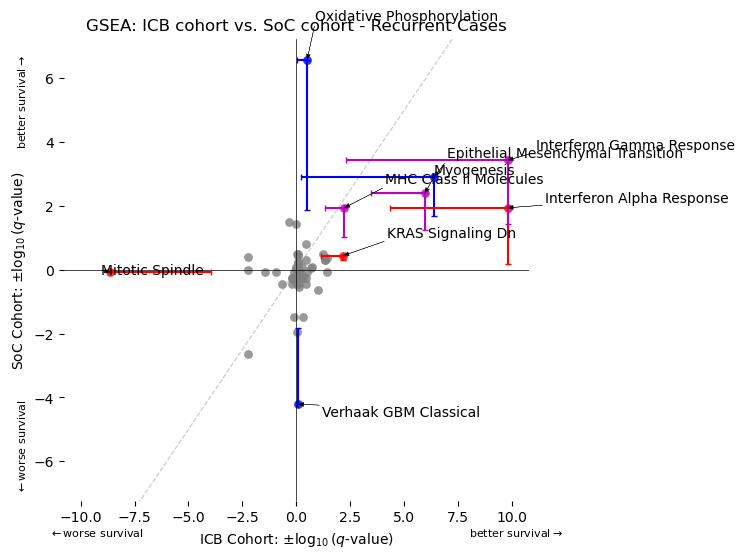

In [17]:
to_annotate = ((limma_pre_rec_leaveONEout_fgsea_summary_df["max_FDR q-val"] < 0.1) | 
               (limma_glass_recurrent_leaveONEout_fgsea_summary_df["max_FDR q-val"] < 0.1))

to_annotate = to_annotate[to_annotate].index.tolist()

fig, ax = gsea_plot(limma_pre_rec_leaveONEout_fgsea_summary_df, 
                    limma_glass_recurrent_leaveONEout_fgsea_summary_df, 
                    limma_pre_recurrent_combined_gsea,
                    to_annotate,
                    figsize=(6,6),
                    seed=314159
              )


ax.set_title("GSEA: ICB cohort vs. SoC cohort - Recurrent Cases")
ax.set_xlabel(r"ICB Cohort: $\pm \log_{10} (q$-value$)$")
ax.set_ylabel(r"SoC Cohort: $\pm \log_{10} (q$-value$)$")

fig.text(0.1, 0.05, "$\leftarrow$worse survival", fontsize=8)  
fig.text(0.8, 0.05, r"better survival$\rightarrow$", fontsize=8) 
fig.text(0.045, 0.125, r"$\leftarrow$worse survival", fontsize=8, rotation=90)  
fig.text(0.045, 0.7, r"better survival$\rightarrow$", fontsize=8, rotation=90)

Gaddy: Want table of NES and Q-value; and worst-case; and best-case; to accompany these plots

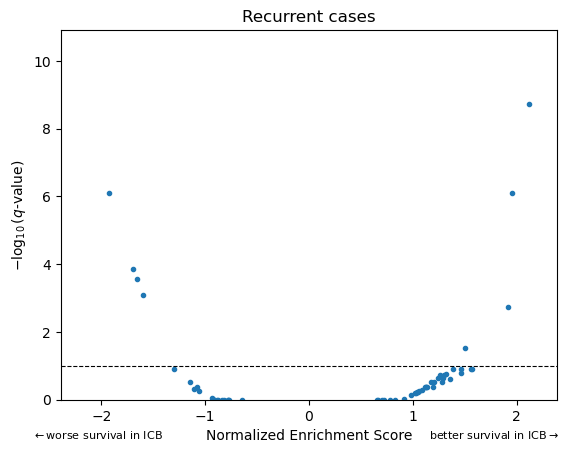

In [18]:
volcano_plot(limma_pre_recurrent_combined_gsea["NES"].values,
             limma_pre_recurrent_combined_gsea["FDR q-val"].values)
plt.title("Recurrent cases")
plt.annotate(r"$\leftarrow$worse survival in ICB", xy=(0.05, 0.03), xycoords="figure fraction", fontsize=8)  
plt.annotate(r"better survival in ICB$\rightarrow$", xy=(0.67, 0.03), xycoords="figure fraction", fontsize=8) 
plt.show()

In [19]:
limma_pre_recurrent_combined_gsea.loc[limma_pre_recurrent_combined_gsea["FDR q-val"] < 0.1, ["NES", "FDR q-val"]].sort_values("NES")

,NES,FDR q-val
Term,,
HALLMARK_G2M_CHECKPOINT,-1.924359,7.673154e-07
HALLMARK_MITOTIC_SPINDLE,-1.695124,1.390404e-04
HALLMARK_E2F_TARGETS,-1.659358,2.816310e-04
HALLMARK_TNFA_SIGNALING_VIA_NFKB,-1.599148,7.967931e-04
HALLMARK_OXIDATIVE_PHOSPHORYLATION,1.503562,3.054605e-02
HALLMARK_ANGIOGENESIS,1.912513,1.885805e-03
HALLMARK_MYOGENESIS,1.955595,7.673154e-07
HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,2.123808,1.878011e-09
